In [84]:
# prepares the notebook for "inline" graphing, and imports matplotlib library
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from os.path import isfile, join

In [85]:
# These functions are used for data analysis.

# these functions are used in determining the type
# of data we are looking at (posthresh, neghold etc)
def isIncreasing(L):
    return L[0] < L[len(L) - 1] and len(L) > 1
def isDecreasing(L):
    return L[0] > L[len(L) - 1] and len(L) > 1
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of voltages and currents as arguments
def sortIntoSide(voltage, current):
    if isIncreasing(voltage) and isIncreasing(current):
        return "posThresh"
    elif isDecreasing(voltage) and isDecreasing(current):
        return "posHold"
    elif isDecreasing(voltage) and isIncreasing(current):
        return "negThresh"
    elif isIncreasing(voltage) and isDecreasing(current):
        return "negHold"
    else: 
        print("???")
        # print("error determining type of data. V: ", voltage, " I: ", current)


In [86]:
# this will take a file name and device size and
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.pos_hold_voltages = []
        self.neg_hold_voltages = []

        self.pos_thresh_voltages = []
        self.neg_thresh_voltages = []

        self.filePath = file_path
        self.get_file_name_from_path()
        self.get_device_number_from_name()
        self.get_sample_number_from_name()
        self.read_all_data()
        self.break_into_runs()
        self.sort_runs_into_neg_pos_thresh_hold()

        # self.sort_runs_into_neg_pos_thresh_hold()

        # self.graph_all_data()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("/GitHub/")[1]

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    def read_all_data(self):

        rows_to_exclude = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'],sep='\t',skiprows=1)
        data = rows_to_exclude.values
        rows_to_exclude.head()
        I_to_skip = data[:,1]
        self.max_current = np.max(I_to_skip) * 0.999
        print("max: ", self.max_current / np.max(I_to_skip), "% of data is being used")
        over_max_current_indexes = ((I_to_skip > self.max_current).nonzero())[0]


        df5 = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'],sep='\t',skiprows=over_max_current_indexes)
        data = df5.values
        df5.head()
        
        self.number_of_data_points = len(data[:,0])
        print("number of data points: ", self.number_of_data_points)

        self.index = np.arange(0, len(data[:,0]))
        
        # self.time = data[:,0]
        interval = average(np.gradient(data[:,0][1:5]))
        # interval = 1
        self.time = np.arange(0, len(data[:,0])) * interval

        self.I = data[:,1]
        self.V = data[:,2]
        self.temps = data[:,3]

        print(self.temps)


        # self.max_current = np.max(self.I) * 0.5
        # print("max: ", self.max_current, "/", np.max(self.I))
        # over_max_current_indexes = ((self.I > self.max_current).nonzero())[0]

        # for i in over_max_current_indexes:
        #     np.delete(self.time, i)
        #     np.delete(self.I, i)
        #     np.delete(self.V, i)
        #     np.delete(self.temps, i)

        self.R = self.V / self.I
        self.R = np.abs(self.R)

        self.all_data = []

        for i in range(0, len(self.V)):
            self.all_data.append({
                'time': self.time[i],
                'I': self.I[i],
                'V': self.V[i],
                'temps': self.temps[i],
                'R': self.R[i]
            })

    def graph_all_data(self):
        plt.rcParams['figure.figsize'] = (9,3)
        plt.title("All Data")
        plt.grid()
        # print("Temp: " , self.temp[0] , " - " , self.temp[len(self.temp) - 1] , " K")
        # plt.text(-1.5, 0.01, "Temp: " + str(self.temp[1]) + " - " + str(self.temp[len(self.temp) - 1]) + " K", fontsize=12)
        # plt.text(-0.5, 0.01, "Device: " + self.device_number, fontsize=12)
        # plt.text(0.5, 0.01, "Sample: " + self.sample_number, fontsize=12)

    
        #  xAxis = self.neg_thresh_runs[run_to_graph]['V']
        # yAxis = self.neg_thresh_runs[run_to_graph]['I']
        # plt.plot(xAxis[self.neg_thresh_voltages[run_to_graph]], yAxis[self.neg_thresh_voltages[run_to_graph]], marker="o", markersize=10, markeredgecolor="yellow", markerfacecolor="red")
        plt.axhline(y = self.max_current, color = 'r', linestyle = '-')
        plt.semilogy(self.V, self.I)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))

    def graph_temp(self):
        plt.title("Temp vs Time")
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        plt.semilogy(self.time, self.temps)
        plt.xlabel('Time (s)')
        plt.ylabel('Temp (K)')
        plt.figure(np.random.randint(1000000000))

    def graph_r_vs_time(self):
        plt.title("Resistance vs Time")
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        plt.semilogy(self.time, self.R)
        plt.xlabel('Time (s)')
        plt.ylabel('Resistance (?)')
        plt.figure(np.random.randint(1000000000))

    def graph_r_vs_temps(self):
        plt.title("Resistance vs Temp")
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        plt.semilogy(self.temps[:], self.R[:])
        plt.xlabel('Temp (K)')
        plt.ylabel(r'Resistance ($\Omega$)')
        plt.figure(np.random.randint(1000000000))

    def graph_voltage_run_vs_current(self, run_number):
        plt.title("IV Curve #" + str(run_number))
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        voltage_to_graph = self.all_data_in_runs[run_number]['V']
        current_to_graph = self.all_data_in_runs[run_number]['I']
        plt.semilogy(voltage_to_graph, current_to_graph)
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))

        # self.all_data_in_runs.append({
        #         'time': self.time[start:stop],
        #         'I': self.I[start:stop],
        #         'V': self.V[start:stop],
        #         'temps': self.temps[start:stop],
        #         'temp': run_temp,
        #         'temp_std': run_temp_std,
        #     })

        
    
    def graph_current_at_voltage(self, voltage_to_graph, voltage_tolerance):
        # find the index of each voltage point that you want to graph and put them into a list
        quarter_volt_indexes = []
        for x in range((int)(len(self.time) * (0/10)), (int)(len(self.time) * (10/10))):
            if ((self.V[x] >= (voltage_to_graph - voltage_tolerance) and self.V[x] <= (voltage_to_graph + voltage_tolerance)) or (self.V[x] <= -(voltage_to_graph - voltage_tolerance) and self.V[x] >= -(voltage_to_graph + voltage_tolerance))):
                quarter_volt_indexes.append(x)

        xAxis = []
        yAxis = []
        for x in quarter_volt_indexes:
            xAxis.append(self.time[x])
            yAxis.append(self.I[x])

        xAxis = np.array(xAxis)
        yAxis = np.array(yAxis)

        plt.title("current at " + str(voltage_to_graph) + " V")
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        plt.plot(xAxis, yAxis)
        plt.xlabel('Time (s)')
        plt.ylabel('Voltage (V)')
        plt.figure(np.random.randint(1000000000))


    def graph_resistance_at_voltage(self, voltage_to_graph, voltage_tolerance):
        # find the index of each voltage point that you want to graph and put them into a list
        quarter_volt_indexes = []
        for x in range((int)(len(self.time) * (0/10)), (int)(len(self.time) * (10/10))):
            if ((self.V[x] >= (voltage_to_graph - voltage_tolerance) and self.V[x] <= (voltage_to_graph + voltage_tolerance)) or (self.V[x] <= -(voltage_to_graph - voltage_tolerance) and self.V[x] >= -(voltage_to_graph + voltage_tolerance))):
                quarter_volt_indexes.append(x)

        xAxis = []
        yAxis = []
        for x in quarter_volt_indexes:
            xAxis.append(self.temps[x])
            yAxis.append(self.R[x])

        xAxis = np.array(xAxis)
        yAxis = (yAxis)

        plt.title("Resistance at " + str(voltage_to_graph) + " V")
        plt.rcParams['figure.figsize'] = (90,3)
        plt.grid()
        plt.semilogy(xAxis, yAxis)

        for i in range(len(xAxis)):
            plt.plot(xAxis[i], yAxis[i], marker="o", markersize=2, markeredgecolor='red', markerfacecolor='red')

        plt.xlabel('Temp (K)')
        plt.ylabel(r'Resistance ($\Omega$)')
        plt.figure(np.random.randint(1000000000))

        

    def graph_runs_data(self, start, stop):
        plt.title("runs: ", start, " - ", stop)
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()
        # print("Temp: " , self.temp[0] , " - " , self.temp[len(self.temp) - 1] , " K")
        # plt.text(-1.5, 0.01, "Temp: " + str(self.temp[1]) + " - " + str(self.temp[len(self.temp) - 1]) + " K", fontsize=12)
        # plt.text(-0.5, 0.01, "Device: " + self.device_number, fontsize=12)
        # plt.text(0.5, 0.01, "Sample: " + self.sample_number, fontsize=12)
        plt.semilogy(self.V[start:stop], self.I[start:stop])
        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))

    def break_into_runs(self):
        # self.max_v = np.amax(self.V)
        # self.min_v = np.amin(self.V)

        self.all_zero_indexes = np.where(self.V == 0.0)[0]
        self.all_zero_indexes = self.all_zero_indexes[4:]
        self.all_zero_indexes = self.all_zero_indexes[:-4]


        self.V_in_runs = []
        self.all_data_in_runs = []
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i]
            stop = self.all_zero_indexes[i+1] + 2
            self.V_in_runs.append(self.V[start:stop])

            run_temp = np.average(self.temps[start:stop])
            run_temp_std = np.std(self.V[start:stop])

            
            self.all_data_in_runs.append({
                'time': self.time[start:stop],
                'I': self.I[start:stop],
                'dI': np.gradient(self.I[start:stop]),
                'ddI': np.gradient(np.gradient(self.I[start:stop])),
                'V': self.V[start:stop],
                'temps': self.temps[start:stop],
                'temp': run_temp,
                'temp_std': run_temp_std,
            })

        self.number_of_runs = len(self.all_zero_indexes) - 1
        print("number of IV curves: ", self.number_of_runs)

    def graph_IV_curve(self, run_to_graph):
        title_time = "  Time =" + str(round(self.all_data_in_runs[run_to_graph]['time'][0])) + " s"
        title_temp = "  Temp =" + str((self.all_data_in_runs[run_to_graph]['temps'][0])) + " K"
        plt.title("IV curve # " + str(run_to_graph) + title_time + title_temp)
        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()

        colors = ['red', 'blue', 'orange', 'green']
        # data_sets = [self.pos_hold_runs[run_to_graph], self.neg_hold_runs[run_to_graph], self.pos_thresh_runs[run_to_graph], self.neg_thresh_runs[run_to_graph]]
        data_sets = []
        data_sets.append(self.neg_hold_runs[run_to_graph])
        data_sets.append(self.pos_hold_runs[run_to_graph])
        data_sets.append(self.pos_thresh_runs[run_to_graph])
        data_sets.append(self.neg_thresh_runs[run_to_graph])
        
        # there are 4 types of runs - posThresh, posHold, negThresh, negHold
        for i in range(4):
            xAxis = data_sets[i]['V']
            yAxis = data_sets[i]['I']
            point_index = np.argmax(data_sets[i]['ddI'])
            if i == 0: 
                point_index-=2
            if i == 1: 
                point_index-=2
            if i == 2: 
                point_index+=1
            if i == 3: 
                point_index+=0
            plt.plot(xAxis[point_index], yAxis[point_index], marker="o", markersize=10, markeredgecolor=colors[i], markerfacecolor=colors[i])
            plt.semilogy(xAxis, yAxis, color=colors[i])

        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))
    
    def sort_runs_into_neg_pos_thresh_hold(self):
        self.pos_runs = []
        self.neg_runs = []

        for run in self.all_data_in_runs:
            if (run['V'][2] > 0):
                self.pos_runs.append(run)
            else:
                self.neg_runs.append(run)

        # self.calculate_gradient_all_data()

        self.pos_thresh_runs = []
        self.pos_hold_runs = []
        self.neg_thresh_runs = []
        self.neg_hold_runs = []


        for run in self.pos_runs:
            # print(run)
            switch_from_thresh_to_hold_index = np.argmax(run['V']) + 1
            end_of_data_index = len(run['V']) - 1

            if (switch_from_thresh_to_hold_index < end_of_data_index):

                voltage_to_sort = run['V'][0 : switch_from_thresh_to_hold_index]
                current_to_sort = run['I'][0 : switch_from_thresh_to_hold_index]
                type_of_data = sortIntoSide(voltage_to_sort, current_to_sort)

                if (type_of_data == "posThresh"):
                    self.pos_thresh_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'dI': run['dI'][0 : switch_from_thresh_to_hold_index],
                        'ddI': run['ddI'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })


                    # print("old: ", {
                    #     'time': run['time'][0 : switch_from_thresh_to_hold_index],
                    #     'I': run['I'][0 : switch_from_thresh_to_hold_index],
                    #     'dI': run['dI'][0 : switch_from_thresh_to_hold_index],
                    #     'ddI': run['ddI'][0 : switch_from_thresh_to_hold_index],
                    #     'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                    #     'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                    #     'temp':  run['temp'], 
                    #     'temp_std':  run['temp_std'],
                    # })
                    # print("new: ", run[:, [0, switch_from_thresh_to_hold_index]])
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.pos_thresh_voltages.append(index_of_voltage)

                if (type_of_data == "posHold"):
                    self.pos_hold_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'dI': run['dI'][0 : switch_from_thresh_to_hold_index],
                        'ddI': run['ddI'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.pos_hold_voltages.append(index_of_voltage)

                if (type_of_data == "negThresh"):
                    self.neg_thresh_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'dI': run['dI'][0 : switch_from_thresh_to_hold_index],
                        'ddI': run['ddI'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.neg_thresh_voltages.append(index_of_voltage)

                if (type_of_data == "negHold"):
                    self.neg_hold_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'dI': run['dI'][0 : switch_from_thresh_to_hold_index],
                        'ddI': run['ddI'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.neg_hold_voltages.append(index_of_voltage)






                # do it all again to the other side
                voltage_to_sort = run['V'][switch_from_thresh_to_hold_index : end_of_data_index]
                current_to_sort = run['I'][switch_from_thresh_to_hold_index : end_of_data_index]
                type_of_data = sortIntoSide(voltage_to_sort, current_to_sort)

                if (type_of_data == "posThresh"):
                    self.pos_thresh_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'dI': run['dI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'ddI': run['ddI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.pos_thresh_voltages.append(index_of_voltage)

                if (type_of_data == "posHold"):
                    self.pos_hold_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'dI': run['dI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'ddI': run['ddI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.pos_hold_voltages.append(index_of_voltage)

                if (type_of_data == "negThresh"):
                    self.neg_thresh_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'dI': run['dI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'ddI': run['ddI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.neg_thresh_voltages.append(index_of_voltage)

                if (type_of_data == "negHold"):
                    self.neg_hold_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'dI': run['dI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'ddI': run['ddI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.neg_hold_voltages.append(index_of_voltage)

            else: 
                print("error in assigning type of data")

        for run in self.neg_runs:
            # print(run)
            switch_from_thresh_to_hold_index = np.argmin(run['V'])
            end_of_data_index = len(run['V']) - 1
            # print(run['V'][2], run['V'][4])

            if (switch_from_thresh_to_hold_index < end_of_data_index):

                voltage_to_sort = run['V'][0 : switch_from_thresh_to_hold_index]
                current_to_sort = run['I'][0 : switch_from_thresh_to_hold_index]
                type_of_data = sortIntoSide(voltage_to_sort, current_to_sort)

                if (type_of_data == "posThresh"):
                    self.pos_thresh_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'dI': run['dI'][0 : switch_from_thresh_to_hold_index],
                        'ddI': run['ddI'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.pos_thresh_voltages.append(index_of_voltage)

                if (type_of_data == "posHold"):
                    self.pos_hold_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'dI': run['dI'][0 : switch_from_thresh_to_hold_index],
                        'ddI': run['ddI'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.pos_hold_voltages.append(index_of_voltage)

                if (type_of_data == "negThresh"):
                    self.neg_thresh_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'dI': run['dI'][0 : switch_from_thresh_to_hold_index],
                        'ddI': run['ddI'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.neg_thresh_voltages.append(index_of_voltage)
                if (type_of_data == "negHold"):
                    self.neg_hold_runs.append({
                        'time': run['time'][0 : switch_from_thresh_to_hold_index],
                        'I': run['I'][0 : switch_from_thresh_to_hold_index],
                        'dI': run['dI'][0 : switch_from_thresh_to_hold_index],
                        'ddI': run['ddI'][0 : switch_from_thresh_to_hold_index],
                        'V':  run['V'][0 : switch_from_thresh_to_hold_index],
                        'temps':  run['temps'][0 : switch_from_thresh_to_hold_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][0 : switch_from_thresh_to_hold_index]))
                    self.neg_hold_voltages.append(index_of_voltage)

                # do it all again to the other side
                voltage_to_sort = run['V'][switch_from_thresh_to_hold_index : end_of_data_index]
                current_to_sort = run['I'][switch_from_thresh_to_hold_index : end_of_data_index]
                type_of_data = sortIntoSide(voltage_to_sort, current_to_sort)

                if (type_of_data == "posThresh"):
                    self.pos_thresh_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'dI': run['dI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'ddI': run['ddI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.pos_thresh_voltages.append(index_of_voltage)
                    
                if (type_of_data == "posHold"):
                    self.pos_hold_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'dI': run['dI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'ddI': run['ddI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                        'index_of_hold': index_of_voltage
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.pos_hold_voltages.append(index_of_voltage)

                if (type_of_data == "negThresh"):
                    self.neg_thresh_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'dI': run['dI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'ddI': run['ddI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.neg_thresh_voltages.append(index_of_voltage)
                if (type_of_data == "negHold"):
                    self.neg_hold_runs.append({
                        'time': run['time'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'I': run['I'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'dI': run['dI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'ddI': run['ddI'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'V':  run['V'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temps':  run['temps'][switch_from_thresh_to_hold_index : end_of_data_index],
                        'temp':  run['temp'], 
                        'temp_std':  run['temp_std'],
                    })
                    index_of_voltage = np.argmax(np.gradient(run['V'][switch_from_thresh_to_hold_index : end_of_data_index]))
                    self.neg_hold_voltages.append(index_of_voltage)

            else: 
                print("error in assigning type of data")

    

max:  0.999 % of data is being used
number of data points:  202131
[317.201  317.243  317.258  ...   4.9995   4.9995   5.0001]
number of IV curves:  2637
???


IndexError: list index out of range

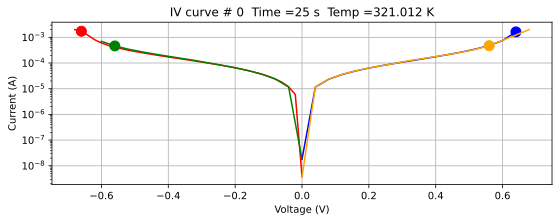

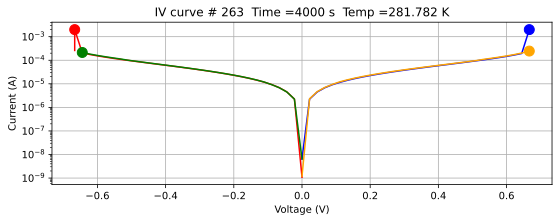

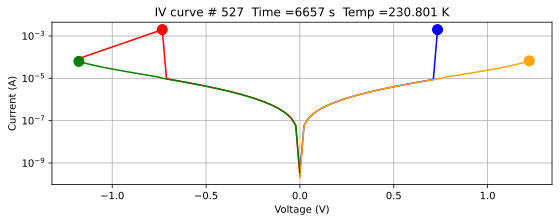

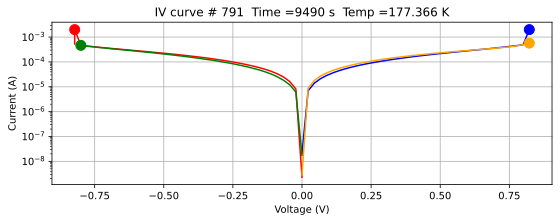

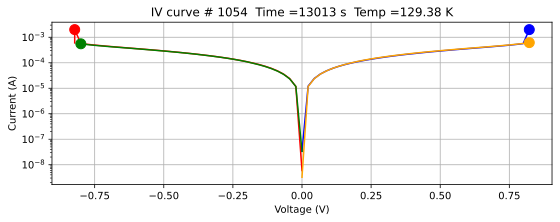

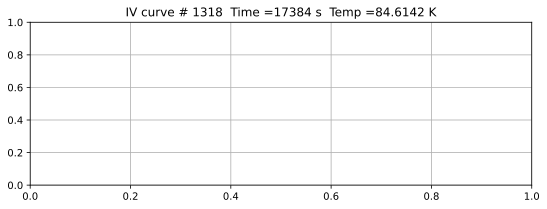

In [87]:

theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");
# theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/Nb02_v2/IVs_NbO2_Ti0_Sam3_051823_D22.txt");
# theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti10_Sam3_042023_D18_try2edited.txt");
# theFile = DataFile(os.getcwd() + "/IVs_NbO2_Ti10_Sam3_042723_D18.txt");


# new data ma6 26
# theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/Nb02_v2/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");
# IVs_NbO2_Ti0_Sam3_052423_D15_cool


theFile.graph_all_data()
# theFile.graph_temp()
# theFile.graph_r_vs_time()
current_threshold = 0.0001
# theFile.graph_current_at_voltage(0.2, current_threshold)
# theFile.graph_current_at_voltage(0.3, current_threshold)
# theFile.graph_current_at_voltage(0.4, current_threshold)
# theFile.graph_current_at_voltage(0.5, current_threshold)
# theFile.graph_r_vs_temps()

number_of_graphs = 10
for x in range(0, number_of_graphs):
  number_of_runs = theFile.number_of_runs * 1
  i = (int)((number_of_runs / number_of_graphs) * x)
  # try:
  theFile.graph_IV_curve(i)
  # except:
    # print("error creating graph")



# theFile.graph_resistance_at_voltage(0.2, current_threshold)
# theFile.graph_resistance_at_voltage(0.3, current_threshold)
# theFile.graph_resistance_at_voltage(0.4, current_threshold)
# theFile.graph_resistance_at_voltage(0.5, current_threshold)

# for x in range(10):
#   number_of_runs = theFile.number_of_runs
#   i = (int)((number_of_runs / 12) * x)
#   print("temp: ", theFile.all_data_in_runs[x]['temp'], " std: ", theFile.all_data_in_runs[x]['temp_std'])
#   # print(theFile.all_data_in_runs[x])
#   theFile.graph_one_run(i)

# theFile.calculate_gradient_all_data()
# theFile.find_max_gradient()

# print(self.pos_hold_runs)
#         print(self.neg_hold_runs)
#         print(self.neg_thresh_runs)
#         print(self.pos_thresh_runs)

In [ ]:
# todo


# resistance at certain temp. split them into pos and neg and thresh and hold. log scale


# print(len(theFile.pos_hold_voltages))
# print(len(theFile.neg_hold_voltages))
# print(len(theFile.pos_thresh_voltages))
# print(len(theFile.neg_thresh_voltages))
# print()

# theFile.max_current = np.max(theFile.I) * 0.9
# print("max: ", theFile.max_current, "/", np.max(theFile.I))
# over_max_current_indexes = ((theFile.I > theFile.max_current).nonzero())[0]
# print(over_max_current_indexes)


# x1 = np.array(([1., -1.]))
# print(x1)
# print(np.abs(x1))

# print(len(theFile.pos_hold_runs))
print(theFile.neg_hold_runs[len(theFile.neg_hold_runs) - 1])
# print(len(theFile.pos_thresh_runs))
# print(len(theFile.neg_thresh_runs))